In [117]:
from collections import defaultdict, Counter
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt
import evaluate
from utils import get_vocab



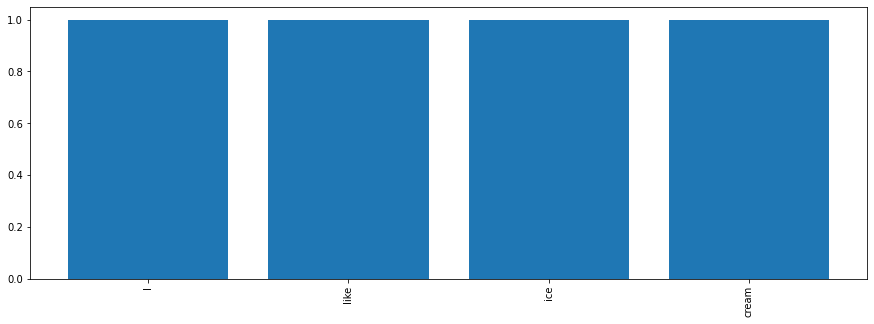

(['I', 'like', 'ice', 'cream'],
 defaultdict(<function utils.get_vocab.<locals>.<lambda>()>,
             {'I': 1, 'like': 2, 'ice': 3, 'cream': 4}),
 defaultdict(<function utils.get_vocab.<locals>.<lambda>()>,
             {1: 'I', 2: 'like', 3: 'ice', 4: 'cream'}))

In [118]:
get_vocab(['I like ice cream'], split=True)

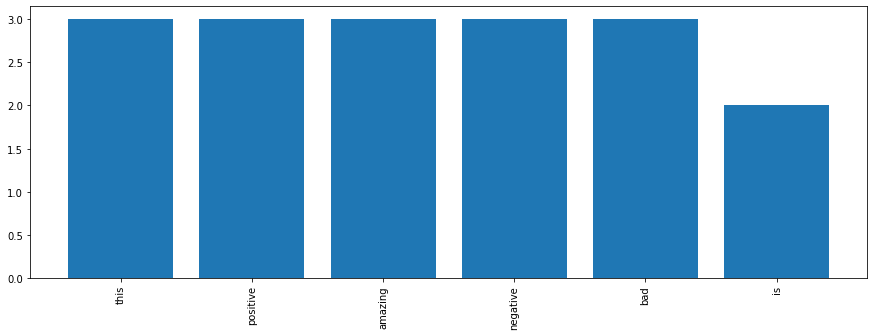

estimated likelilihood and probability of each class sums to 1


/tmp/ipykernel_2723/3821935996.py:37: RuntimeWarning: divide by zero encountered in log
  self.likelihood[c] = np.log(self.likelihood[c])


[0]

In [81]:

class NaiveBayes:
    def __init__(self, vocab_size, word2int, num_classes, int2word):
        """NaiveBayes model classifier with bag of words to featurize.

        Args:
            class_labels List[str]: list of class labels
            vocab_size int: number of words 
        """
        self.num_classes = num_classes
        self.prior = np.zeros(num_classes)
        self.likelihood = defaultdict(lambda : np.ones(vocab_size))
        self.word2int = word2int
        self.int2word = int2word

        pass 


    def fit(self, X, Y, split=False, logging=False, logging_interval=1000):
        i = 0
        for x, y in zip(X, Y):
            i += 1
            if i % logging_interval == 0 and logging:
                print(i)
            self.prior[y] += 1 / len(Y)
            if split:
                x = x.split(' ')
            for word in x:
                self.likelihood[y][self.word2int[word]] += 1

        

        for c, probs in self.likelihood.items():
            probs[0] = 0
            self.likelihood[c] = probs / np.sum(probs)
        
            assert(np.allclose(np.sum(self.likelihood[c]), 1, 1e-2))
            self.likelihood[c] = np.log(self.likelihood[c])
        print('estimated likelilihood and probability of each class sums to 1')

        
    def predict(self, X, split=False, scores=False):
        predictions = []
        for x in X:
            if split:
                x = x.split(' ')
            probs = np.zeros(self.num_classes)
            for c in range(self.num_classes):
                probs[c] += self.prior[c]
                for word in x:
                    if self.word2int[word] > 0:
                        probs[c] += self.likelihood[c][self.word2int[word]]
            if not scores:
                probs = probs.argmax()
            predictions.append(probs)
        return predictions

    def visualize_likelihood(self):
        # Get top 5 words associated with each class. 
        for c in range(self.num_classes):
            prob = self.likelihood[c]
            top_prob_indices = np.argsort(prob)[::-1][0:25]
            top_words = [self.int2word[index] for index in top_prob_indices ]
            plt.title(f'distribution of top words associated with class {c}')
            plt.bar(top_words, prob[top_prob_indices])
            plt.xticks(rotation=90)
            plt.show()
            

toy_X = [
        ['this', 'is', 'positive', 'amazing'],
        ['positive', 'amazing'],
        ['positive'],
        ['amazing'],
        ['this', 'is','negative','bad'],
        ['negative','bad', 'this'],
        ['negative'],
        ['bad']
    ]
toy_Y = [1, 1, 1,1, 0, 0, 0, 0]
toy_vocab, toy_word2int, toy_int2word = get_vocab(toy_X)
toy_naive_bayes = NaiveBayes(vocab_size=len(toy_vocab) + 1, word2int=toy_word2int, num_classes=2, int2word=toy_int2word)
toy_naive_bayes.fit(toy_X, toy_Y)
toy_naive_bayes.predict([['negative']])
#toy_naive_bayes.visualize_likelihood()

In [36]:
train_dataset = load_dataset('imdb', split='train')
test_dataset = load_dataset('imdb', split='test')

train_dataset['label'][15000]

Reusing dataset imdb (/home/ajrfhp/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Reusing dataset imdb (/home/ajrfhp/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


1

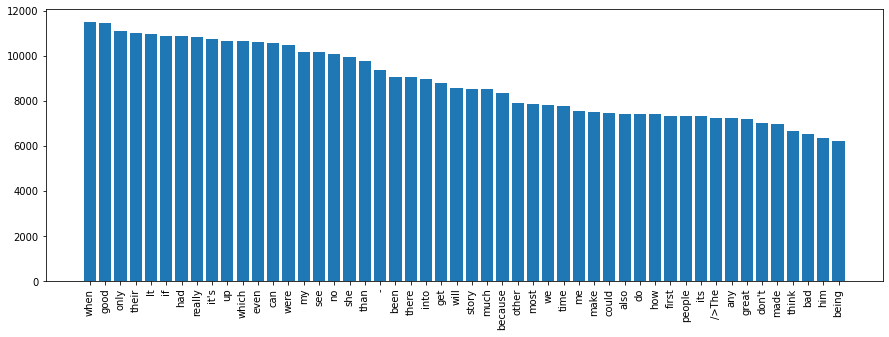

estimated likelilihood and probability of each class sums to 1


/tmp/ipykernel_2723/3821935996.py:37: RuntimeWarning: divide by zero encountered in log
  self.likelihood[c] = np.log(self.likelihood[c])


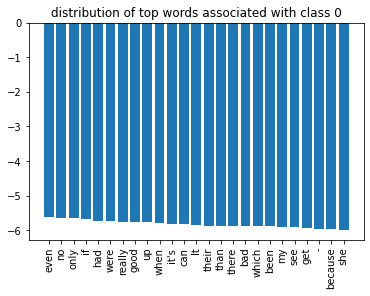

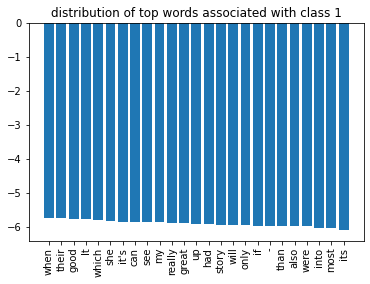

In [114]:
vocab, word2int, int2word = get_vocab(train_dataset['text'], split=True, vocab_size=100000, visualize=True, num_stop_words=50)
naive_bayes = NaiveBayes(vocab_size=len(vocab) + 1, word2int=word2int, num_classes=2, int2word=int2word)
naive_bayes.fit(train_dataset['text'], train_dataset['label'], split=True)


naive_bayes.visualize_likelihood()

- Not bad for a simple model. 
    - Top words associated with each class after UNK 
    - negative - terrible, boring, awful, worse 
    - Positive - amazing, fine, well, highly

In [115]:
for example in ['this is an amazing movie', 'crappy movie', 'crap', 'shit', 'glorious', 'majestic', 'love this', 'entertaining', 'awful', 'terrible writing', 'clumsy writing']:
    print(example, naive_bayes.predict([example], split=True, scores=False))

this is an amazing movie [1]
crappy movie [0]
crap [0]
shit [0]
glorious [1]
majestic [1]
love this [1]
entertaining [1]
awful [0]
terrible writing [0]
clumsy writing [0]


In [116]:
predictions = naive_bayes.predict(test_dataset['text'], split=True)
accuracy_metric = evaluate.load("accuracy")
accuracy_metric.compute(references=predictions, predictions=test_dataset['label'])

{'accuracy': 0.83924}